In [1]:
# Imports
from sympy import * 
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import ae353_quadrotor
init_printing() # This function makes the outputs of SymPy look neater and easier to read

#### Dynamical Systems Section

In [2]:
# Mass and moment of inertia of the drone (arbitrary for now)
m = 0.695    # The mass of the quadrotor in kg
Ixx = 0.00405068  # The moment of inertia of the quadrotor in 
Iyy = 0.00405068  # The mass of the quadrotor in kg
Izz = 0.00781016  # The mass of the quadrotor in kg
g = 9.81

In [3]:
px_W, py_W, pz_W = symbols('p_x, p_y, p_z')             # Defines position in world frame
vx_B, vy_B, vz_B = symbols('v_x, v_y, v_z')             # Defines velocity in body frame
phi, theta, psi = symbols('phi, theta, psi')            # Defines roll (phi), pitch (theta), and yaw (psi) angles
wx_B, wy_B, wz_B = symbols('omega_x, omega_y, omega_z') # Defines angular velocities in body frame

# Defines roll, pitch, and yaw rotation matrices that describe the drone's orientation in the world frame
taux_B, tauy_B, tauz_B, fz_B = symbols('tau_x, tau_y, tau_z, f_z') # Defines torques and net z-force in body frame

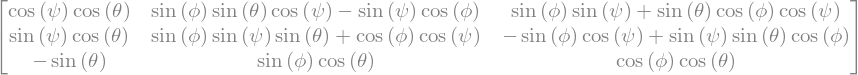

In [4]:
#rotation matrices that define the orientation of the quadrotor in the world coordinate system
p_W = Matrix([[px_W],[py_W], [pz_W]]) 
v_B = Matrix([[vx_B],[vy_B],[vz_B]])
w_B = Matrix([[wx_B],[wy_B], [wz_B]])
Rx = Matrix([[1,0,0],[0,cos(phi),-sin(phi)],[0,sin(phi),cos(phi)]])
Ry = Matrix([[cos(theta),0,sin(theta)],[0,1,0],[-sin(theta),0,cos(theta)]])
Rz = Matrix([[cos(psi),-sin(psi),0],[sin(psi),cos(psi),0],[0,0,1]])

R_BW = Rz@Ry@Rx # converts body to world (drone to inertial)
R_WB = Rx@Ry@Rz # converts world to body (inertial to drone)

# Obtains the net torque vector
tau_B = Matrix([[taux_B],[tauy_B],[tauz_B]])
tau_B = simplify(tau_B)

# Obtains the gravity force and convert to body coordiantes
g_W = Matrix([[0.],[0.],[-m*g]]) # gravity in world
g_B = R_WB@g_W # gravity in body

# Obtains the net force vector in body
f_B = g_B + Matrix([[0.],[0.],[fz_B]])
R_BW

In [5]:
# Assembles the moment of inertia matrix
I_B = Matrix([[Ixx,0.,0.],[0.,Iyy,0.],[0.,0.,Izz]])

In [6]:
# Converts the body-fixed velocity to world-fixed velocity to get the derivatives of position 
# px, py, pz rate as a function of orientation and body-fixed velocities
v_W = R_BW@v_B # xdot

In [7]:
# Applies Newton's Second Law to get the derivative of the velocity in body-fixed coordinates 
# Body-fixed velocity rates as a function of orientation, body-fixed velocities, and applied forces
v_B_dot = (1/m)*(f_B - w_B.cross(m*v_B)) # xdotdot

In [8]:
# Defines the transformation that takes roll, pitch, and yaw rates to body-fixed angular rates
# Inverts the transformation to get a matrix that takes body-fixed angular rates to roll, pitch, and yaw rates
# Converts the body-fixed angular rates to roll, pitch, and yaw rates 

ex = Matrix([[1], [0], [0]])
ey = Matrix([[0], [1], [0]])
ez = Matrix([[0], [0], [1]])
M = Matrix.hstack(ex, Rx.T@ey, (Ry@Rx).T@ez)
rpy_dot = (M.inv())@w_B # ANGLES

In [9]:
# Applies Euler's equation to get the time derivative of the angular velocities of the quadrotor in the quadrotor frame
# Time derivative of the angular velocities in the body-fixed frame 
w_B_dot = I_B.inv() @ (tau_B - w_B.cross(I_B@w_B)) # ANGULAR VELOCITIES

In [10]:
# Assembles all differential equations
f = Matrix.vstack(v_W,
                  v_B_dot,
                  rpy_dot,
                  w_B_dot)
f = simplify(f,full=True)

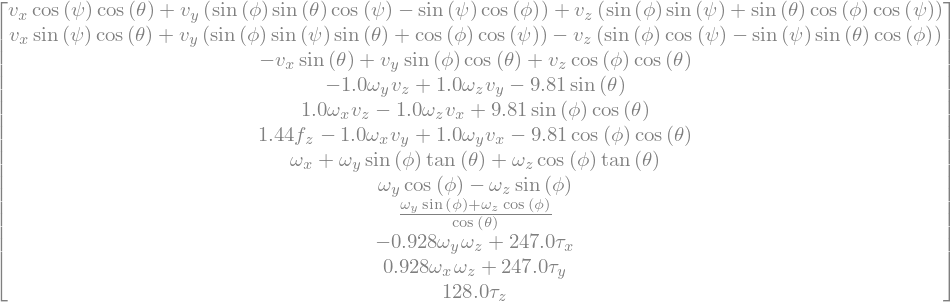

In [11]:
N(f,3)

The equations of motion for the dynamic model are now in the form:

$$\begin{bmatrix} \dot{p_x} \\ \dot{p_y} \\ \dot{p_z} \\ \dot{v_x} \\ \dot{v_y} \\ \dot{v_z} \\ \dot{\phi} \\ \dot{\theta} \\ \dot{\psi} \\ \dot{\omega_x} \\ \dot{\omega_y} \\ \dot{\omega_z} \end{bmatrix}=f\left(p_x, p_y, p_z, v_x, v_y, v_z, \phi, \theta, \psi, \omega_x, \omega_y, \omega_z, \tau_x, \tau_y, \tau_z, f_z\right)$$

#### Control Systems Section

In [12]:
# Obtains equilibrium points
px_e = py_e = pz_e = vx_e = vy_e = vz_e = phi_e = theta_e = psi_e = omegax_e = omegay_e = omegaz_e = taux_e = tauy_e = tauz_e = 0.
fz_e = 9.81/1.43884892086331

m_e = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
n_e = np.array([0, 0, 0, 0])

# Checks if the function value when plugging the equilibrium points equals to 0
f_num = lambdify([px_W, py_W, pz_W, vx_B, vy_B, vz_B, phi, theta, psi, wx_B, wy_B, wz_B, taux_B, tauy_B, tauz_B, fz_B], f)
f_eq = f_num(px_e, py_e, pz_e, vx_e, vy_e, vz_e, phi_e, theta_e, psi_e, omegax_e, omegay_e, omegaz_e, taux_e, tauy_e, tauz_e, fz_e)
Matrix(f_eq)

In [13]:
# Solving for Coefficient Matrix A
A = lambdify([px_W, py_W, pz_W, vx_B, vy_B, vz_B, phi, theta, psi, wx_B, wy_B, wz_B, taux_B, tauy_B, tauz_B, fz_B], 
                 f.jacobian([px_W, py_W, pz_W, vx_B, vy_B, vz_B, phi, theta, psi, wx_B, wy_B, wz_B]))
A_num = A(px_e, py_e, pz_e, vx_e, vy_e, vz_e, phi_e, theta_e, psi_e, omegax_e, omegay_e, omegaz_e, taux_e, tauy_e, tauz_e, fz_e)

# Solving for Coefficient Matrix B
B = lambdify([px_W, py_W, pz_W, vx_B, vy_B, vz_B, phi, theta, psi, wx_B, wy_B, wz_B, taux_B, tauy_B, tauz_B, fz_B], 
                 f.jacobian([taux_B, tauy_B, tauz_B, fz_B]))
B_num = B(px_e, py_e, pz_e, vx_e, vy_e, vz_e, phi_e, theta_e, psi_e, omegax_e, omegay_e, omegaz_e, taux_e, tauy_e, tauz_e, fz_e)

In [14]:
#Creating Q and R Matrices
Q = np.diag([10, 100000, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1])
R = np.diag([10, 10, 10, 10])

P = linalg.solve_continuous_are(A_num, B_num, Q, R)
K = linalg.inv(R) @ B_num.T @ P

In [20]:
# Define the initial conditions for the state and observer state
x0s = np.array([[0],
               [0],
               [0],
               [0],
               [0],
               [0],
               [0],
               [0],
               [0],
               [0],
               [0],
               [0]])

x0 = x0s

# Combine the initial conditions
initial_conditions = np.hstack((x0.flatten()))

# Define the function for the state-space system
def test1(t, x):
    goal = Matrix([[0,0,1,0,0,0,0,0,0,0,0,9.81*0.695]])
    goal = np.array(goal).astype(np.float64)
    x_actual = (x - goal).T
    
    u = -K@x_actual  # Control input
    
    # State-space dynamics
    dx_actual = A_num@x_actual + B_num@u
    
    return np.hstack((dx_actual.flatten()))
# Time span for integration
t_span = (0, 120)

# Integrate the system with the observer using solve_ivp
solution = solve_ivp(test1, t_span, initial_conditions, method='RK45', dense_output=False)

# Extract the state and observer state trajectories
x_actual_traj = solution.y[:A_num.shape[0], :]
x_actual_traj = np.around(x_actual_traj, decimals=4)

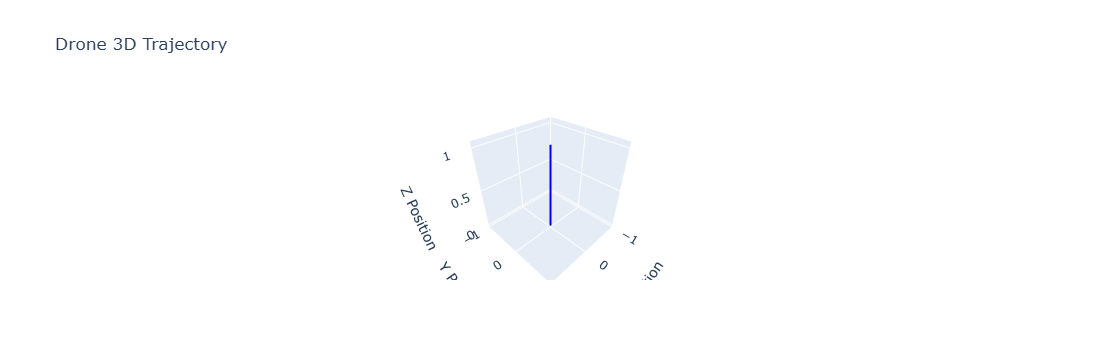

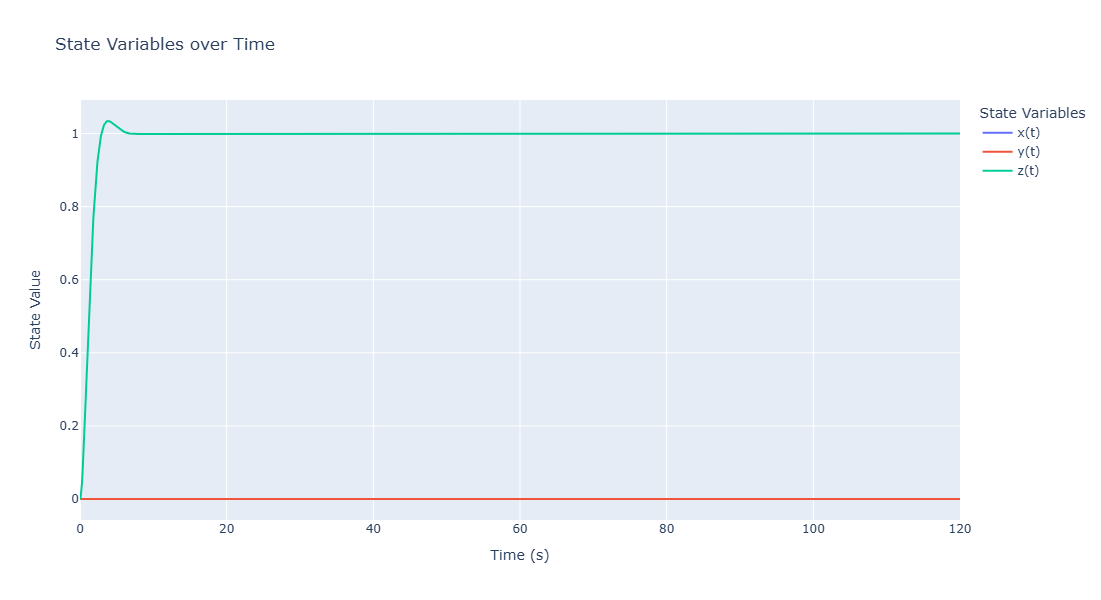

In [22]:
fig_3d = go.Figure()
fig_3d.add_trace(go.Scatter3d(
    x=x_actual_traj[0],  # X trajectory (e.g., x position)
    y=x_actual_traj[1],  # Y trajectory (e.g., y position)
    z=x_actual_traj[2],  # Z trajectory (e.g., z position)
    mode='lines',
    line=dict(color='blue', width=4),
    name='Trajectory'
))
fig_3d.update_layout(
    title="Drone 3D Trajectory",
    scene=dict(
        xaxis_title='X Position',
        yaxis_title='Y Position',
        zaxis_title='Z Position'
    )
)
fig_3d.show()

# Create individual 2D plots for x, y, z over time
fig_2d = go.Figure()

# Add x(t)
fig_2d.add_trace(go.Scatter(
    x=time_values,
    y=x_actual_traj[0],
    mode='lines',
    name='x(t)'
))

# Add y(t)
fig_2d.add_trace(go.Scatter(
    x=time_values,
    y=x_actual_traj[1],
    mode='lines',
    name='y(t)'
))

# Add z(t)
fig_2d.add_trace(go.Scatter(
    x=time_values,
    y=x_actual_traj[2],
    mode='lines',
    name='z(t)'
))

# Update layout for 2D plots
fig_2d.update_layout(
    title="State Variables over Time",
    xaxis_title="Time (s)",
    yaxis_title="State Value",
    legend_title="State Variables",
    height=600
)

fig_2d.show()